# Identify generic genes and pathways using subset of training compendium

Studies have found that some genes are more likely to be differentially expressed even across a wide range of experimental designs. These generic genes and subsequent pathways are not necessarily specific to the biological process being studied but instead represent a more systematic change. 

We have developed an approach, outlined below, to automatically identify these generic genes and pathways. We have validated this simulation approach can identify generic genes and pathways in the analysis notebooks: [human_general_analysis](../human_general_analysis/) and [human_cancer_analysis](../human_cancer_analysis/). Here

This notebook applies this approach to identify generic genes and pathways in the pseudomonas compendium. 

**Steps to identify generic genes:**
1. Simulates N gene expression experiments using [ponyo](https://github.com/ajlee21/ponyo)
2. Perform DE analysis to get association statistics for each gene

In this case the DE analysis is based on the experimental design of the template experiment, described in the previous [notebook](1_process_pseudomonas_data.ipynb). 
The template experiment is [GEOD-33245](https://www.ebi.ac.uk/arrayexpress/experiments/E-GEOD-33245/?s_sortby=col_8&s_sortorder=ascending), which contains multiple different comparisons including WT vs *crc* mutants, WT vs *cbr* mutants in different conditions. So the DE analysis is comparing WT vs mutant.

3. For each gene, aggregate statistics across all simulated experiments 
4. Rank genes based on this aggregated statistic

**Steps to identify generic gene sets (pathways):**
1. Using the same simulated experiments from above, perform GSEA analysis. This analysis will determine whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list of genes, where genes are ranked by log fold change, indicating a correlation with change in expression.
2. For each gene set (pathway), aggregate statistics across all simulated experiments
3. Rank gene sets based on this aggregated statistic

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

from rpy2.robjects import pandas2ri
pandas2ri.activate()

from ponyo import utils, simulate_expression_data
from generic_expression_patterns_modules import process, stats, ranking

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_filename = os.path.abspath(os.path.join(base_dir,
                                           "configs",
                                           "config_pseudomonas_pao1.tsv"))
params = utils.read_config(config_filename)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
num_runs = params['num_simulated']
project_id = params['project_id']
metadata_col_id = params['metadata_colname']
raw_template_filename = params['raw_template_filename']
processed_template_filename = params['processed_template_filename']
normalized_compendium_filename = params['normalized_compendium_filename']
scaler_filename = params['scaler_filename']
col_to_rank_genes = params['rank_genes_by']
col_to_rank_pathways = params['rank_pathways_by']
statistic = params['gsea_statistic']

# Load metadata file with grouping assignments for samples
sample_id_metadata_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_process_samples.tsv")

# Load metadata file with grouping assignments for samples
metadata_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_groups.tsv"
)

# Load pickled file
scaler = pickle.load(open(scaler_filename, "rb"))

In [4]:
# Output files
gene_summary_filename = os.path.join(
    base_dir, 
    dataset_name, 
    f"generic_gene_summary_{project_id}_pao1.tsv"
)
pathway_summary_filename = os.path.join(
    base_dir, 
    dataset_name, 
    f"generic_pathway_summary_{project_id}_pao1.tsv"
)

### Simulate experiments using selected template experiment
Workflow:

1. Get the gene expression data for the selected template experiment
2. Encode this experiment into a latent space using the trained VAE model
3. Linearly shift the encoded template experiment in the latent space
4. Decode the samples. This results in a new experiment
5. Repeat steps 1-4 to get multiple simulated experiments

In [5]:
# Note: We are manually changing the function to suit our nex experiment where we 
# subset our training compendium. Ponyo will be updated to address this change to
# be more robust to user inputs
import glob
import warnings
from keras.models import load_model
from sklearn import preprocessing

def get_sample_ids(experiment_id, dataset_name, sample_id_colname):
    """
    Returns sample ids (found in gene expression df) associated with
    a given list of experiment ids (found in the metadata)

    Arguments
    ----------
    experiment_ids_file: str
        File containing all cleaned experiment ids

    dataset_name: str
        Name for analysis directory. Either "Human" or "Pseudomonas"

    sample_id_colname: str
        Column header that contains sample id that maps expression data
        and metadata

    """
    base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

    if "pseudomonas" in dataset_name.lower():
        # metadata file
        mapping_file = os.path.join(
            base_dir, dataset_name, "data", "metadata", "sample_annotations.tsv"
        )

        # Read in metadata
        metadata = pd.read_csv(mapping_file, header=0, sep="\t", index_col=0)

        selected_metadata = metadata.loc[experiment_id]
        sample_ids = list(selected_metadata[sample_id_colname])

    else:
        # metadata file
        mapping_file = os.path.join(
            base_dir, dataset_name, "data", "metadata", "recount2_metadata.tsv"
        )

        # Read in metadata
        metadata = pd.read_csv(mapping_file, header=0, sep="\t", index_col=0)

        selected_metadata = metadata.loc[experiment_id]
        sample_ids = list(selected_metadata[sample_id_colname])

    return sample_ids

def shift_template_experiment_tmp(
    normalized_data_file,
    selected_experiment_id,
    sample_id_colname,
    NN_architecture,
    dataset_name,
    scaler,
    local_dir,
    base_dir,
    run,
):
    """
    Generate new simulated experiment using the selected_experiment_id as a template
    experiment and shifting this template experiment in the latent space to a new
    location. This shifted experiment will be the new simulated experiment.

    This will return a file with a single simulated experiment following the workflow mentioned.
    This function can be run multiple times to generate multiple simulated experiments from a
    single selected_experiment_id.

    Arguments
    ----------
    normalized_data_file: str
        File containing normalized gene expression data

        ------------------------------| PA0001 | PA0002 |...
        05_PA14000-4-2_5-10-07_S2.CEL | 0.8533 | 0.7252 |...
        54375-4-05.CEL                | 0.7789 | 0.7678 |...
        ...                           | ...    | ...    |...

    selected_experiment_id: str
        Experiment id selected as template

    sample_id_colname: str
        Column header that contains sample id that maps expression data and metadata

    NN_architecture: str
        Name of neural network architecture to use.
        Format 'NN_<intermediate layer>_<latent layer>'

    dataset_name: str
        Name for analysis directory. Either "Human" or "Pseudomonas"

    scaler: minmax model
        Model used to transform data into a different range

    local_dir: str
        Parent directory on local machine to store intermediate results

    base_dir: str
        Root directory containing analysis subdirectories

    run: int
        Simulation run

    Returns
    --------
    simulated_data_file: str
        File containing simulated gene expression data

    """

    # Files
    NN_dir = os.path.join(base_dir, dataset_name, "models", NN_architecture)
    latent_dim = NN_architecture.split("_")[-2] # Here we manually changed the index to work

    model_encoder_file = glob.glob(os.path.join(NN_dir, "*_encoder_model.h5"))[0]

    weights_encoder_file = glob.glob(os.path.join(NN_dir, "*_encoder_weights.h5"))[0]

    model_decoder_file = glob.glob(os.path.join(NN_dir, "*_decoder_model.h5"))[0]

    weights_decoder_file = glob.glob(os.path.join(NN_dir, "*_decoder_weights.h5"))[0]

    # Load saved models
    loaded_model = load_model(model_encoder_file, compile=False)
    loaded_decode_model = load_model(model_decoder_file, compile=False)

    loaded_model.load_weights(weights_encoder_file)
    loaded_decode_model.load_weights(weights_decoder_file)

    # Read data
    normalized_data = pd.read_csv(normalized_data_file, header=0, sep="\t", index_col=0)

    # Get corresponding sample ids
    sample_ids = get_sample_ids(selected_experiment_id, dataset_name, sample_id_colname)

    # Gene expression data for selected samples
    selected_data_df = normalized_data.loc[sample_ids]

    # Encode selected experiment into latent space
    data_encoded = loaded_model.predict_on_batch(selected_data_df)
    data_encoded_df = pd.DataFrame(data_encoded, index=selected_data_df.index)

    # Get centroid of original data
    centroid = data_encoded_df.mean(axis=0)

    # Add individual vectors(centroid, sample point) to new_centroid

    # Encode original gene expression data into latent space
    data_encoded_all = loaded_model.predict_on_batch(normalized_data)
    data_encoded_all_df = pd.DataFrame(data_encoded_all, index=normalized_data.index)

    data_encoded_all_df.head()

    # Find a new location in the latent space by sampling from the latent space
    encoded_means = data_encoded_all_df.mean(axis=0)
    encoded_stds = data_encoded_all_df.std(axis=0)

    latent_dim = int(latent_dim)
    new_centroid = np.zeros(latent_dim)

    for j in range(latent_dim):
        new_centroid[j] = np.random.normal(encoded_means[j], encoded_stds[j])

    shift_vec_df = new_centroid - centroid

    simulated_data_encoded_df = data_encoded_df.apply(
        lambda x: x + shift_vec_df, axis=1
    )

    # Decode simulated data into raw gene space
    simulated_data_decoded = loaded_decode_model.predict_on_batch(
        simulated_data_encoded_df
    )

    simulated_data_decoded_df = pd.DataFrame(
        simulated_data_decoded,
        index=simulated_data_encoded_df.index,
        columns=selected_data_df.columns,
    )

    # Un-normalize the data in order to run DE analysis downstream
    simulated_data_scaled = scaler.inverse_transform(simulated_data_decoded_df)

    simulated_data_scaled_df = pd.DataFrame(
        simulated_data_scaled,
        columns=simulated_data_decoded_df.columns,
        index=simulated_data_decoded_df.index,
    )

    # Save template data for visualization validation
    test_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        "template_normalized_data_" + selected_experiment_id + "_test.txt",
    )

    selected_data_df.to_csv(test_file, float_format="%.3f", sep="\t")

    # Save
    out_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        "selected_simulated_data_" + selected_experiment_id + "_" + str(run) + ".txt",
    )

    simulated_data_scaled_df.to_csv(out_file, float_format="%.3f", sep="\t")

    out_encoded_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_encoded_data_{selected_experiment_id}_{run}.txt",
    )

    simulated_data_encoded_df.to_csv(out_encoded_file, float_format="%.3f", sep="\t")

In [6]:
# Simulate multiple experiments
# This step creates the following files in "<local_dir>/pseudo_experiment/" directory:           
#   - selected_simulated_data_SRP012656_<n>.txt
#   - selected_simulated_encoded_data_SRP012656_<n>.txt
#   - template_normalized_data_SRP012656_test.txt
# in which "<n>" is an integer in the range of [0, num_runs-1] 
os.makedirs(os.path.join(local_dir, "pseudo_experiment"), exist_ok=True)
for run_id in range(num_runs):
    shift_template_experiment_tmp(
        normalized_compendium_filename,
        project_id,
        metadata_col_id,
        NN_architecture,
        dataset_name,
        scaler,
        local_dir,
        base_dir,
        run_id)

'# Simulate multiple experiments\n# This step creates the following files in "<local_dir>/pseudo_experiment/" directory:           \n#   - selected_simulated_data_SRP012656_<n>.txt\n#   - selected_simulated_encoded_data_SRP012656_<n>.txt\n#   - template_normalized_data_SRP012656_test.txt\n# in which "<n>" is an integer in the range of [0, num_runs-1] \nos.makedirs(os.path.join(local_dir, "pseudo_experiment"), exist_ok=True)\nfor run_id in range(num_runs):\n    shift_template_experiment_tmp(\n        normalized_compendium_filename,\n        project_id,\n        metadata_col_id,\n        NN_architecture,\n        dataset_name,\n        scaler,\n        local_dir,\n        base_dir,\n        run_id)'

### Process template and simulated data

* Remove samples not required for comparison. 
* Make sure ordering of samples matches metadata for proper comparison

In [7]:
if not os.path.exists(sample_id_metadata_filename):
    sample_id_metadata_filename = None

stats.process_samples_for_limma(
    raw_template_filename,
    metadata_filename,
    processed_template_filename,
    sample_id_metadata_filename,
)

for i in range(num_runs):
    simulated_filename = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_data_{project_id}_{i}.txt"
    )
    stats.process_samples_for_limma(
        simulated_filename,
        metadata_filename,
        None,
        sample_id_metadata_filename,
)

'if not os.path.exists(sample_id_metadata_filename):\n    sample_id_metadata_filename = None\n\nstats.process_samples_for_limma(\n    raw_template_filename,\n    metadata_filename,\n    processed_template_filename,\n    sample_id_metadata_filename,\n)\n\nfor i in range(num_runs):\n    simulated_filename = os.path.join(\n        local_dir,\n        "pseudo_experiment",\n        f"selected_simulated_data_{project_id}_{i}.txt"\n    )\n    stats.process_samples_for_limma(\n        simulated_filename,\n        metadata_filename,\n        None,\n        sample_id_metadata_filename,\n)'

In [8]:
# Quick check
template_data = pd.read_csv(
    processed_template_filename, 
    header=0,
    index_col=0,
    sep="\t"
)

assert(template_data.shape[0] == 4)

### Differential expression analysis

In [9]:
# Create subdirectory: "<local_dir>/DE_stats/"
os.makedirs(os.path.join(local_dir, "DE_stats"), exist_ok=True)

In [10]:
%%R -i metadata_filename -i project_id -i processed_template_filename -i local_dir -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

get_DE_stats_limma(metadata_filename,
                   project_id, 
                   processed_template_filename,
                   "template",
                   local_dir,
                   "real")

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarni

[1] 15


In [11]:
%%R -i metadata_filename -i project_id -i base_dir -i local_dir -i num_runs -o num_sign_DEGs_simulated

source(paste0(base_dir,'/generic_expression_patterns_modules/DE_analysis.R'))

num_sign_DEGs_simulated <- c()

for (i in 0:(num_runs-1)){
    simulated_data_filename <- paste(
        local_dir, 
        "pseudo_experiment/selected_simulated_data_",
        project_id,
        "_", 
        i,
        ".txt",
        sep=""
    )
    
    run_output <- get_DE_stats_limma(
        metadata_filename,
        project_id, 
        simulated_data_filename,
        "simulated",
        local_dir,
        i
    )
    num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, run_output)
}

### Rank genes

In [12]:
analysis_type = "DE"
template_DE_stats_filename = os.path.join(
    local_dir,
    "DE_stats",
    f"DE_stats_template_data_{project_id}_real.txt"
)
template_DE_stats, simulated_DE_summary_stats = ranking.process_and_rank_genes_pathways(
    template_DE_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_genes,
)

### Gene summary table

In [13]:
summary_gene_ranks = ranking.generate_summary_table(
    template_DE_stats_filename,
    template_DE_stats,
    simulated_DE_summary_stats,
    col_to_rank_genes,
    local_dir,
    'gene',
    params
)

summary_gene_ranks.sort_values(by="Z score", ascending=False).head()

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Gene ID,Adj P-value (Real),Rank (Real),abs(logFC) (Real),logFC (Real),Median adj p-value (simulated),Rank (simulated),Mean abs(logFC) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
PA2195,PA2195,0.013404,5504.0,1.549834,-1.549834,0.733340,3092.0,0.12754,0.077098,25,18.447771
PA4726,PA4726,0.000010,5549.0,4.530917,-4.530917,0.554727,4636.5,0.24804,0.242961,25,17.627806
PA2260,PA2260,0.034741,5387.0,0.953635,0.953635,0.741730,1713.0,0.08960,0.050718,25,17.036139
PA3915,PA3915,0.000920,5535.0,2.065593,-2.065593,0.391412,5308.0,0.28870,0.109285,25,16.259220
PA5168,PA5168,0.005137,5475.0,1.292737,-1.292737,0.707260,3344.5,0.13870,0.075171,25,15.352146


In [14]:
# Add gene name as column to summary dataframe
summary_gene_ranks = ranking.add_pseudomonas_gene_name_col(summary_gene_ranks, base_dir)
summary_gene_ranks.sort_values(by="Z score", ascending=False).head()

,Gene ID,Adj P-value (Real),Rank (Real),abs(logFC) (Real),logFC (Real),Median adj p-value (simulated),Rank (simulated),Mean abs(logFC) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score,Gene Name
PA2195,PA2195,0.013404,5504.0,1.549834,-1.549834,0.733340,3092.0,0.12754,0.077098,25,18.447771,hcnC
PA4726,PA4726,0.000010,5549.0,4.530917,-4.530917,0.554727,4636.5,0.24804,0.242961,25,17.627806,cbrB
PA2260,PA2260,0.034741,5387.0,0.953635,0.953635,0.741730,1713.0,0.08960,0.050718,25,17.036139,NaN
PA3915,PA3915,0.000920,5535.0,2.065593,-2.065593,0.391412,5308.0,0.28870,0.109285,25,16.259220,moaB1
PA5168,PA5168,0.005137,5475.0,1.292737,-1.292737,0.707260,3344.5,0.13870,0.075171,25,15.352146,dctQ


In [15]:
# Check if there is an NaN values, there should not be
summary_gene_ranks.isna().any()

Gene ID                              False
Adj P-value (Real)                   False
Rank (Real)                          False
abs(logFC) (Real)                    False
logFC (Real)                         False
Median adj p-value (simulated)       False
Rank (simulated)                     False
Mean abs(logFC) (simulated)          False
Std deviation (simulated)            False
Number of experiments (simulated)    False
Z score                              False
Gene Name                             True
dtype: bool

In [16]:
# Create `gene_summary_filename`
summary_gene_ranks.to_csv(gene_summary_filename, sep='\t')

## Compare gene ranking

r = 0.3743837960745028
p = 3.621704632637787e-184
ci_low = 0.3509873530823741
ci_high = 0.3988725360726553


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


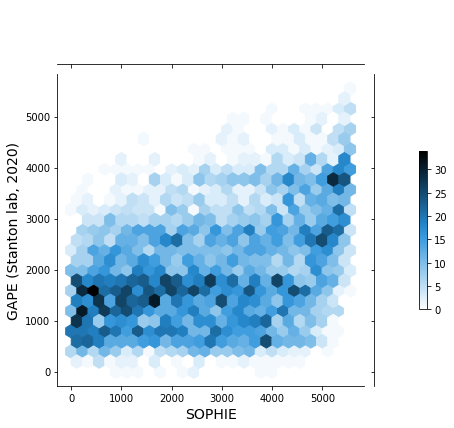

In [17]:
# Get generic genes identified by Crow et. al.
GAPE_filename = params['reference_gene_filename']
ref_gene_col = params['reference_gene_name_col']
ref_rank_col = params['reference_rank_col']

figure_filename = f"gene_ranking_{col_to_rank_genes}_pao1.svg"

corr, shared_ranking = ranking.compare_gene_ranking(
    summary_gene_ranks,
    GAPE_filename,
    ref_gene_col,
    ref_rank_col,
    figure_filename
)

In [18]:
# Get genes that are highly generic in both
generic_both = shared_ranking[(shared_ranking["Rank (simulated)"]>4500) & (shared_ranking["prop DEGs"]>3500)]
generic_both.to_csv(os.path.join(local_dir, "SOPHIE_GAPE_generic.tsv"), sep="\t")

In [19]:
# Get genes that are highly generic by SOPHIE but not by GAPE
generic_SOPHIE_only = shared_ranking[(shared_ranking["Rank (simulated)"]>4500) & (shared_ranking["prop DEGs"]<2000)]
generic_SOPHIE_only.to_csv(os.path.join(local_dir, "SOPHIE_generic_only.tsv"), sep="\t")

**Takeaway:**

* X-axis: gene ranking using SOPHIE (trained on Pseudomonas compendium containing ~1K experiments)
* Y-axis: gene ranking using GAPE (curated set of 73 experiments)

* Compared to the correlation plot comparing SOPHIE trained on the full pseudomonas compendium vs GAPE experiments [here](2_identify_generic_genes_pathways.ipynb), it looks like there is more noise in the above correlation plot. Looking up the experiment ids associated with GAPE [here](https://github.com/DartmouthStantonLab/GAPE/blob/main/Pa_GSEnum_unzip.rds) it looks like GAPE does contain a mix of PAO1, PA14 and clinical strains. So by subsetting out training compendium to only represent PAO1 patterns, which is adding more noise to the bottom left of the plot as expected (genes that GAPE finds generic are not found by SOPHIE due to our limited representation in our training compendium)

### GSEA 
**Goal:** To detect modest but coordinated changes in prespecified sets of related genes (i.e. those genes in the same pathway or share the same GO term).

1. Ranks all genes based using DE association statistics. 
2. An enrichment score (ES) is defined as the maximum distance from the middle of the ranked list. Thus, the enrichment score indicates whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list (indicating a correlation with change in expression). 
3. Estimate the statistical significance of the ES by a phenotypic-based permutation test in order to produce a null distribution for the ES( i.e. scores based on permuted phenotype)

In [20]:
# Create "<local_dir>/GSEA_stats/" subdirectory
os.makedirs(os.path.join(local_dir, "GSA_stats"), exist_ok=True)

In [21]:
# Load pathway data
adage_kegg_DB_filename = params['pathway_DB_filename']

In [22]:
# Need to format data into tab-delimited matrix
# with columns= KEGG pathway name, description, gene ids
# Each gene ids is tab separated
adage_kegg_DB_processed_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "adage_kegg_DB_process_filename.gmt"
)
stats.format_pseudomonas_pathway_DB(adage_kegg_DB_filename, local_dir, adage_kegg_DB_processed_filename)

In [23]:
%%R -i base_dir -i template_DE_stats_filename -i adage_kegg_DB_processed_filename -i statistic -o template_enriched_pathways

source(paste0(base_dir, '/generic_expression_patterns_modules/GSEA_analysis.R'))

out_filename <- paste(local_dir, 
                     "GSA_stats/GSEA_stats_template_data_",
                     project_id,
                     "_real.txt", 
                     sep = "")

template_enriched_pathways <- find_enriched_pathways(template_DE_stats_filename, adage_kegg_DB_processed_filename, statistic)
write.table(as.data.frame(template_enriched_pathways[1:7]), file = out_filename, row.names = F, sep = "\t")

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: Rcpp

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [24]:
print(template_enriched_pathways.shape)
template_enriched_pathways[template_enriched_pathways['padj'] < 0.05].sort_values(by='padj').head()

(169, 8)


,pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
168,"KEGG-Module-M00178: Ribosome, bacteria",0.000113,0.000973,0.914364,6.154521,0.0,55,None
91,KEGG-Pathway-pae00010: Glycolysis / Gluconeoge...,0.000121,0.000973,0.451513,2.576971,0.0,35,None
90,KEGG-Pathway-pae00540: Lipopolysaccharide bios...,0.000132,0.000973,0.523175,2.373764,0.0,19,None
145,"KEGG-Module-M00009: Citrate cycle (TCA cycle, ...",0.000128,0.000973,0.682962,3.288370,0.0,22,None
162,KEGG-Module-M00360: Aminoacyl-tRNA biosynthesi...,0.000129,0.000973,0.714398,3.376481,0.0,21,None


In [25]:
%%R -i project_id -i local_dir -i adage_kegg_DB_processed_filename -i num_runs -i statistic

source(paste0(base_dir, '/generic_expression_patterns_modules/GSEA_analysis.R'))

# New files created: "<local_dir>/GSEA_stats/GSEA_stats_simulated_data_<project_id>_<n>.txt"
for (i in 0:(num_runs-1)) {
    simulated_DE_stats_filename <- paste(local_dir, 
                                     "DE_stats/DE_stats_simulated_data_", 
                                     project_id,
                                     "_", 
                                     i,
                                     ".txt",
                                     sep = "")
    
    out_filename <- paste(local_dir, 
                     "GSA_stats/GSEA_stats_simulated_data_",
                     project_id,
                     "_",
                     i,
                     ".txt", 
                     sep = "")
    
    enriched_pathways <- find_enriched_pathways(simulated_DE_stats_filename, adage_kegg_DB_processed_filename, statistic) 
    
    # Remove column with leading edge since its causing parsing issues
    write.table(as.data.frame(enriched_pathways[1:7]), file = out_filename, row.names = F, sep = "\t")
}

### Rank pathways 

In [26]:
analysis_type = "GSA"
template_GSEA_stats_filename = os.path.join(
    local_dir,
    "GSA_stats",
    f"GSEA_stats_template_data_{project_id}_real.txt"    
)
template_GSEA_stats, simulated_GSEA_summary_stats = ranking.process_and_rank_genes_pathways(
    template_GSEA_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_pathways,
    "GSEA"
)

### Pathway summary table

In [27]:
# Create intermediate file: "<local_dir>/gene_summary_table_<col_to_rank_pathways>.tsv"
summary_pathway_ranks = ranking.generate_summary_table(
    template_GSEA_stats_filename,
    template_GSEA_stats,
    simulated_GSEA_summary_stats,
    col_to_rank_pathways,
    local_dir,
    'pathway',
    params
)

summary_pathway_ranks.sort_values(by='Rank (simulated)', ascending=False).head()

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Pathway ID,Adj P-value (Real),Rank (Real),padj (Real),Median adj p-value (simulated),Rank (simulated),Mean padj (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
pathway,,,,,,,,,,
"KEGG-Module-M00178: Ribosome, bacteria","KEGG-Module-M00178: Ribosome, bacteria",0.000973,157.0,0.000973,0.00129,162.5,0.001283,0.000167,25,-1.861053
KEGG-Pathway-pae00190: Oxidative phosphorylation - Pseudomonas aeruginosa PAO1,KEGG-Pathway-pae00190: Oxidative phosphorylati...,0.000973,157.0,0.000973,0.00129,162.5,0.001283,0.000167,25,-1.861053
KEGG-Pathway-pae00020: Citrate cycle (TCA cycle) - Pseudomonas aeruginosa PAO1,KEGG-Pathway-pae00020: Citrate cycle (TCA cycl...,0.000973,157.0,0.000973,0.00129,162.5,0.001283,0.000167,25,-1.861053
"KEGG-Module-M00011: Citrate cycle, second carbon oxidation, 2-oxoglutarate => oxaloacetate","KEGG-Module-M00011: Citrate cycle, second carb...",0.000973,157.0,0.000973,0.00129,162.5,0.001314,0.000233,25,-1.467433
KEGG-Pathway-pae00970: Aminoacyl-tRNA biosynthesis - Pseudomonas aeruginosa PAO1,KEGG-Pathway-pae00970: Aminoacyl-tRNA biosynth...,0.000973,157.0,0.000973,0.00129,162.5,0.001283,0.000167,25,-1.861053


In [29]:
# Create `pathway_summary_filename`
summary_pathway_ranks.to_csv(pathway_summary_filename, sep='\t')

**Quick check:**

Looks like Ribosomes are found to be significantly differentiated in the template and across 25 simulated experiments. So this pathway looks to be generic, which is consistent with findings from [Crow. et. al.](https://www.pnas.org/content/116/13/6491.abstract), using Human data. This is also consistent with [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2679180/) which observed that Ribosome proteins have many different functions in *S. cerevisiae*, which might explain their variability across a wide range of contexts.

* Need to think about why it might make sense that Ribosomes being generic in Humans would also imply that they are generic in P. aeruginosa.